In [10]:
from scapy.all import * 
import pandas as pd 
import numpy as np 
import binascii 
import seaborn as sns
sns.set(color_codes=True)

In [11]:
num_of_packets_to_sniff = 100
pcap = sniff(count=num_of_packets_to_sniff)
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
100
<Sniffed: TCP:96 UDP:0 ICMP:0 Other:4>


<Ether  dst=52:54:00:12:35:02 src=08:00:27:ca:c1:43 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=40 id=36365 flags=DF frag=0 ttl=64 proto=tcp chksum=0x5037 src=10.0.2.15 dst=172.217.163.163 |<TCP  sport=41502 dport=http seq=1520394410 ack=75200704 dataofs=5 reserved=0 flags=A window=63882 chksum=0x5ca6 urgptr=0 |>>>

In [12]:
cd Desktop


[Errno 2] No such file or directory: 'Desktop'
/home/shaumaya/Desktop


In [5]:
pcap = pcap + rdpcap("/home/shaumaya/Desktop/phishingattack.pcap")

In [6]:
pcap


<Sniffed+phishingattack.pcap: TCP:838 UDP:37 ICMP:0 Other:18>

In [20]:
ethernet_frame = pcap[101]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload 
print(ethernet_frame.summary())
print(ip_packet.summary())
print(segment.summary())
print(data.summary()) 
ethernet_frame.show()

Ether / IP / TCP 192.168.1.100:42796 > 104.87.132.38:https A
IP / TCP 192.168.1.100:42796 > 104.87.132.38:https A
TCP 192.168.1.100:42796 > 104.87.132.38:https A

###[ Ethernet ]### 
  dst       = 00:23:eb:6b:ff:2a
  src       = 6c:0b:84:6a:1d:d8
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 52
     id        = 51345
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = tcp
     chksum    = 0xc3a8
     src       = 192.168.1.100
     dst       = 104.87.132.38
     \options   \
###[ TCP ]### 
        sport     = 42796
        dport     = https
        seq       = 33069039
        ack       = 70761040
        dataofs   = 8
        reserved  = 0
        flags     = A
        window    = 282
        chksum    = 0xaeb0
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (1037077976, 2903004480))]



In [21]:
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])


from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet.IP'>
<class 'scapy.layers.inet.TCP'>
Ethernet <Ether from Sniffed+phishingattack.pcap: TCP:836 UDP:37 ICMP:0 Other:20>
IP <IP from Sniffed+phishingattack.pcap: TCP:836 UDP:37 ICMP:0 Other:0>
TCP <TCP from Sniffed+phishingattack.pcap: TCP:836 UDP:0 ICMP:0 Other:0>
UDP <UDP from Sniffed+phishingattack.pcap: TCP:0 UDP:37 ICMP:0 Other:0>


In [22]:
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
  
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

df = df.reset_index()
df = df.drop(columns="index")

In [23]:
print(df.iloc[0])

print(df.shape)

df.head()

df.tail()
df['src']

df[['src','dst','sport','dport']]

version                     4
ihl                         5
tos                         0
len                        40
id                      60343
flags                      DF
frag                        0
ttl                        64
proto                       6
chksum                  59998
src                 10.0.2.15
dst            151.101.193.69
options                     0
time              1.59618e+09
sport                   44518
dport                     443
seq                 831729891
ack                 160383752
dataofs                     5
reserved                    0
flags                       A
window                  65535
chksum                  25812
urgptr                      0
options                  None
payload                     0
payload_raw               b''
payload_hex               b''
Name: 0, dtype: object
(873, 28)


,src,dst,sport,dport
0,10.0.2.15,151.101.193.69,44518,443
1,10.0.2.15,142.250.67.65,59590,443
2,151.101.193.69,10.0.2.15,443,44518
3,142.250.67.65,10.0.2.15,443,59590
4,10.0.2.15,104.19.154.83,60982,443
...,...,...,...,...
868,216.58.217.100,192.168.1.100,80,47596
869,192.168.1.100,216.58.217.100,47596,80
870,216.58.217.100,192.168.1.100,80,47596
871,192.168.1.100,216.58.217.100,47596,80


In [24]:
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

print("# Top Destination Address")
print(df['dst'].describe(),"\n\n")

frequent_address = df['src'].describe()['top']

print("# Who is Top Address Speaking to?")
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

print("# Who is the top address speaking to (Destination Ports)")
print(df[df['src'] == frequent_address]['dport'].unique(),"\n\n")

print("# Who is the top address speaking to (Source Ports)")
print(df[df['src'] == frequent_address]['sport'].unique(),"\n\n")

# Top Source Address
count               873
unique               54
top       192.168.1.100
freq                414
Name: src, dtype: object 


# Top Destination Address
count               873
unique               55
top       192.168.1.100
freq                363
Name: dst, dtype: object 


# Who is Top Address Speaking to?
['52.84.125.48' '104.87.132.38' '104.87.145.70' '173.201.44.188'
 '23.52.91.27' '52.1.131.18' '104.87.133.16' '72.21.91.29' '54.87.193.254'
 '23.54.187.27' '52.21.208.23' '52.22.15.101' '75.75.75.75'
 '172.217.7.164' '184.154.127.226' '54.164.88.31' '66.235.147.240'
 '216.58.217.134' '216.58.217.100' '104.87.150.49'] 


# Who is the top address speaking to (Destination Ports)
[443 80 53] 


# Who is the top address speaking to (Source Ports)
[46100 42796 42798 47592 34068 49956 39856 53294 47196 54764 53400 54396
 60164 47166 47034 57166 46028 46030 46032 46034 46036 46038 46040 40388
 42772 40410 33416 47442 57282 46042 46044 46046 46048 47695 44253 46050
 46052

In [25]:
print("Unique Source Addresses")
print(df['src'].unique())

print()

print("Unique Destination Addresses")
print(df['dst'].unique())

Unique Source Addresses
['10.0.2.15' '151.101.193.69' '142.250.67.65' '104.19.154.83'
 '216.58.200.134' '104.16.2.35' '216.58.200.136' '198.187.29.23'
 '192.0.76.3' '216.58.203.14' '172.217.166.78' '172.217.26.226'
 '140.82.112.25' '142.250.67.129' '142.250.67.166' '216.58.196.65'
 '13.35.226.59' '185.199.108.153' '142.250.67.42' '104.17.212.204'
 '35.185.75.107' '151.101.152.238' '104.22.70.197' '172.217.167.129'
 '104.244.42.8' '104.17.71.176' '192.0.73.2' '151.101.128.223'
 '104.17.237.204' '104.17.230.204' '104.18.20.191' '151.101.154.109'
 '104.16.133.229' '192.168.1.100' '52.84.125.48' '104.87.132.38'
 '104.87.145.70' '173.201.44.188' '23.52.91.27' '52.1.131.18'
 '104.87.133.16' '72.21.91.29' '54.87.193.254' '23.54.187.27'
 '52.21.208.23' '52.22.15.101' '75.75.75.75' '172.217.7.164'
 '184.154.127.226' '54.164.88.31' '216.58.217.134' '66.235.147.240'
 '216.58.217.100' '104.87.150.49']

Unique Destination Addresses
['151.101.193.69' '142.250.67.65' '10.0.2.15' '104.19.154.83'
 '216

In [26]:
print("Unique Source Addresses")
print(df['src'].unique())

print()

print("Unique Destination Addresses")
print(df['dst'].unique())

Unique Source Addresses
['10.0.2.15' '151.101.193.69' '142.250.67.65' '104.19.154.83'
 '216.58.200.134' '104.16.2.35' '216.58.200.136' '198.187.29.23'
 '192.0.76.3' '216.58.203.14' '172.217.166.78' '172.217.26.226'
 '140.82.112.25' '142.250.67.129' '142.250.67.166' '216.58.196.65'
 '13.35.226.59' '185.199.108.153' '142.250.67.42' '104.17.212.204'
 '35.185.75.107' '151.101.152.238' '104.22.70.197' '172.217.167.129'
 '104.244.42.8' '104.17.71.176' '192.0.73.2' '151.101.128.223'
 '104.17.237.204' '104.17.230.204' '104.18.20.191' '151.101.154.109'
 '104.16.133.229' '192.168.1.100' '52.84.125.48' '104.87.132.38'
 '104.87.145.70' '173.201.44.188' '23.52.91.27' '52.1.131.18'
 '104.87.133.16' '72.21.91.29' '54.87.193.254' '23.54.187.27'
 '52.21.208.23' '52.22.15.101' '75.75.75.75' '172.217.7.164'
 '184.154.127.226' '54.164.88.31' '216.58.217.134' '66.235.147.240'
 '216.58.217.100' '104.87.150.49']

Unique Destination Addresses
['151.101.193.69' '142.250.67.65' '10.0.2.15' '104.19.154.83'
 '216

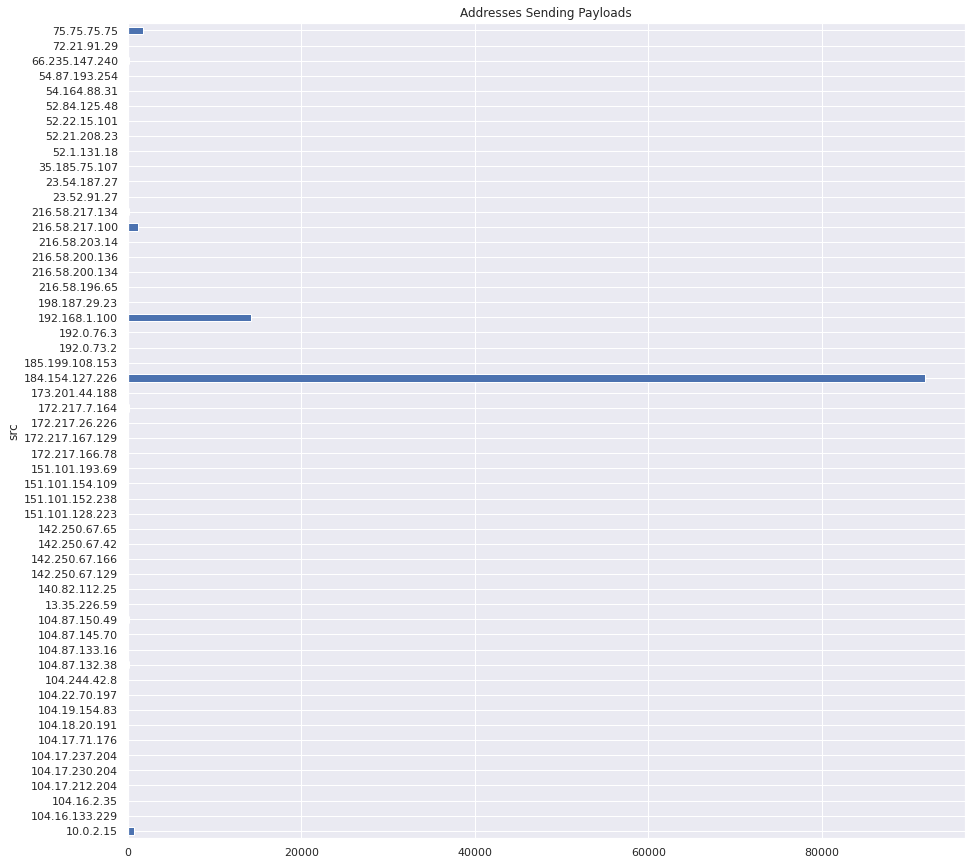

In [40]:
source_addresses = df.groupby("src")['payload'].sum()

source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(15,15))

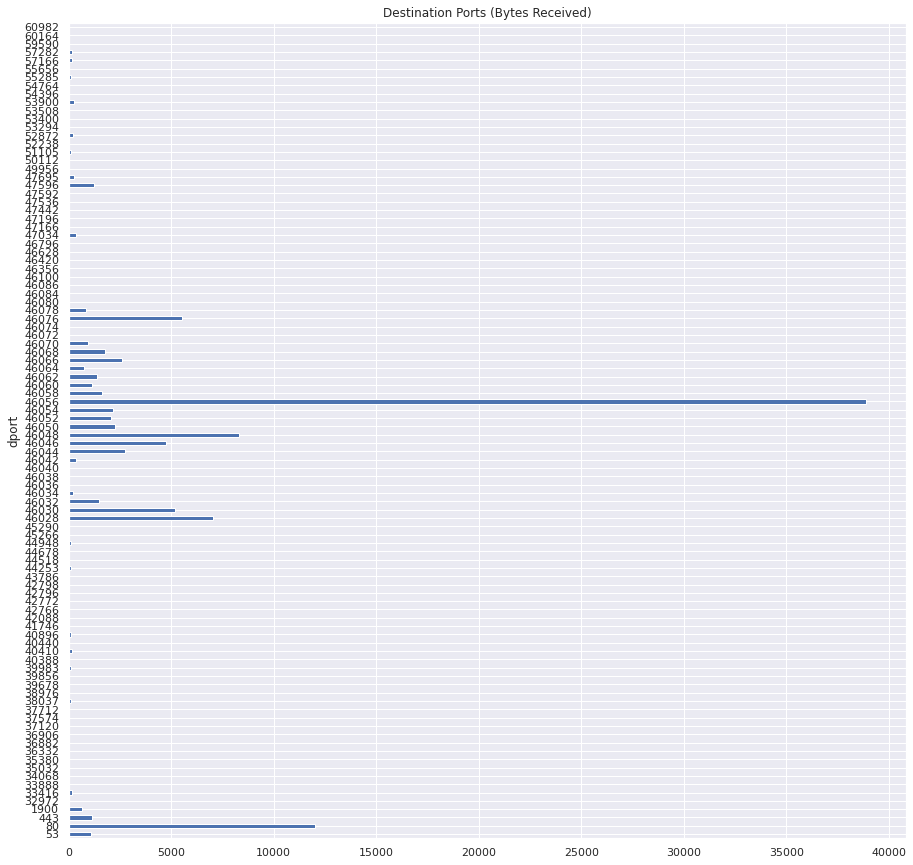

In [49]:
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(15,15))

Text(0.5, 1.0, 'History of bytes sent by most frequent address')

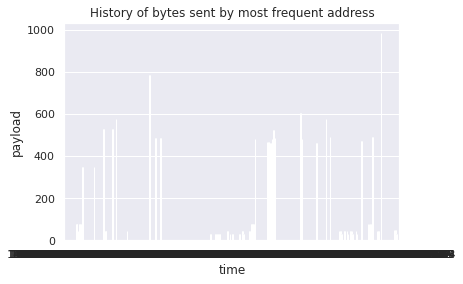

In [50]:

frequent_address_df = df[df['src'] == frequent_address]
x = frequent_address_df['payload'].tolist()
sns.barplot(x="time", y="payload", data=frequent_address_df[['payload','time']],
            label="Total", color="b").set_title("History of bytes sent by most frequent address")

184.154.127.226 May be a suspicious address


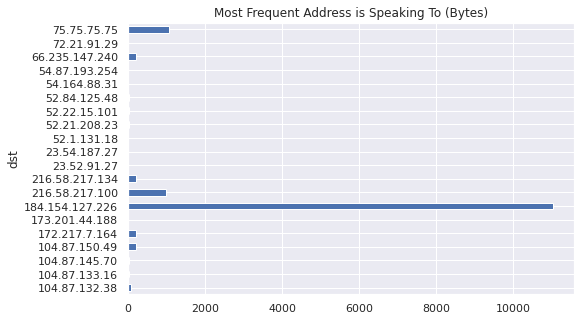

In [52]:
frequent_address_df = df[df['src']==frequent_address]

frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

suspicious_ip = frequent_address_groupby.sort_values(ascending=False).index[0]
print(suspicious_ip, "May be a suspicious address")

suspicious_df = frequent_address_df[frequent_address_df['dst']==suspicious_ip]